In [211]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import os
import rootpath

In [3]:
def get_cpd_df(file, aspect):
    """
    Get the dataframe for change point detection algorithm.
    :param file: file from "cpd_aspects"
    :param aspect: aspect from topics.
    :return: dataframe.
    """
    df = pd.read_csv(file)
    df.drop_duplicates(['sentence'], keep='first', inplace=True)  # drop duplicates based on sentence
    df = df.sort_values('date')

    df_new = df[df[aspect] == True]
    # df_new = df_new[df_new["renovation"] == True]

    print('length of df :', len(df))
    print('length of df_new', len(df_new))
    cpd_df = df_new.groupby(['date', 'uid'])['sentiment'].mean().reset_index()
    cpd_df = cpd_df.groupby('date')['sentiment'].mean().reset_index()

    print(cpd_df.head(3))

    # print("lenght of cpd_df:", len(cpd_df))
    return cpd_df, df_new

In [135]:
root_dir = rootpath.detect()

test_file = 'data/cpd_aspects/164#41af2a52-407d-4c39-863f-57c6b3791920'
testpath = os.path.join(root_dir, test_file)
print(testpath)

cpd_df , _ = get_cpd_df(testpath, "room")

/home/yiyi/Documents/masterarbeit/CPD/data/cpd_aspects/164#41af2a52-407d-4c39-863f-57c6b3791920
length of df : 29132
length of df_new 3247
         date  sentiment
0  2015-01-01   0.489041
1  2015-01-02   0.401239
2  2015-01-03  -0.073607


In [136]:
cpd_df.head(2)

,date,sentiment
0,2015-01-01,0.489041
1,2015-01-02,0.401239


# ewm

In [199]:
cpd_df['ewm'] = cpd_df['sentiment'].ewm(span=100).mean()

In [200]:
cpd_df['ewm']

0       0.489041
1       0.444701
2       0.268465
3       0.199732
4       0.219488
          ...   
1168   -0.031252
1169   -0.031153
1170   -0.020649
1171   -0.029924
1172   -0.033550
Name: ewm, Length: 1173, dtype: float64

In [201]:
cpd_df['diff']= cpd_df['ewm']- cpd_df['sentiment']

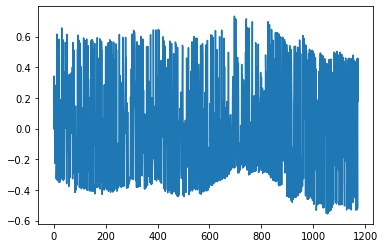

In [202]:
plt.plot(cpd_df['diff'])

In [204]:
peak_indexes = peakutils.indexes(cpd_df['diff'], thres=0.9, min_dist=100)
peak_indexes

array([ 31, 302, 403, 696, 826, 960])

#  RULSIFITTING

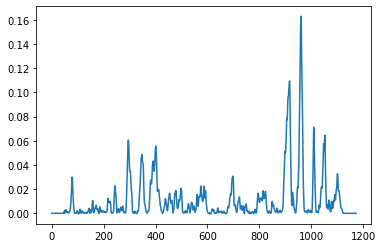

In [212]:
detector = DRChangeRateEstimator(sliding_window=3,
                                                               pside_len=50,
                                                               cside_len=50,
                                                               mergin=-1,
                                                               trow_offset=0,
                                                               tcol_offset=0)
detector.build(estimation_method="RuLSIFitting",
                          options=detector.RuLSIF_OPTION)

change_rates = detector.transform(cpd_df['diff'])
change_rates = np.nan_to_num(change_rates)
plt.plot(change_rates)

In [213]:
plt.savefig('rulsifitting.png')

<Figure size 432x288 with 0 Axes>

In [215]:
peak_indexes = peakutils.indexes(change_rates, thres=0.1, min_dist=150)
peak_indexes

array([ 79, 295, 499, 698, 960])

In [139]:
data_x = cpd_df.sentiment

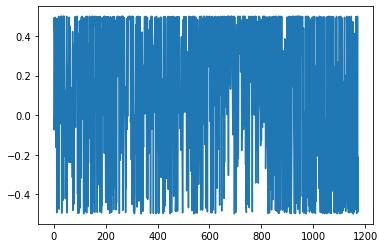

In [140]:
plt.plot(data_x)

In [141]:
import numpy as np
from change_point_detector.density_ratio_estimator import DRChangeRateEstimator
from change_point_detector.test_dataset import TestDataSet
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
detector = DRChangeRateEstimator(sliding_window=20,
                                                               pside_len=50,
                                                               cside_len=50,
                                                               mergin=-1,
                                                               trow_offset=0,
                                                               tcol_offset=0)
detector.build(estimation_method="RuLSIFitting",
                          options=detector.RuLSIF_OPTION)

In [193]:
change_rates = detector.transform(data_x)

In [194]:
change_rates = np.nan_to_num(change_rates)

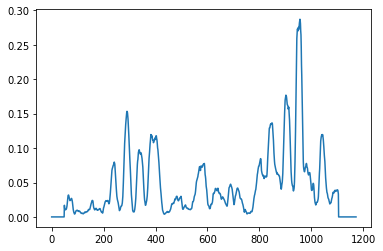

In [195]:
plt.plot(change_rates)

In [196]:
# peak_search
import peakutils
peak_indexes = peakutils.indexes(change_rates, thres=0.3, min_dist=100)

In [197]:
peak_indexes

array([290, 403, 848, 956])

# VON MISER FISHER MEAN 

In [184]:
detector_mfm = DRChangeRateEstimator(sliding_window=5,
                                 pside_len=5,
                                 cside_len=5,
                                 mergin=-2,
                                 trow_offset=3,
                                 tcol_offset=3)
detector_mfm.build(estimation_method="von_mises_fisher",
               options=detector.MEAN_OPTION)
change_rates_mfm = detector.transform(data_x)

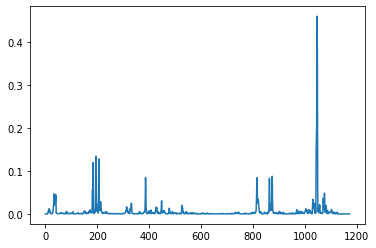

In [185]:
change_rates_mfm = np.nan_to_num(change_rates_mfm)
plt.plot(change_rates_mfm)

In [190]:
peak_indexes = peakutils.indexes(change_rates_mfm, thres=0.1, min_dist=100)

In [191]:
peak_indexes

array([  33,  195,  386,  874, 1047])

# VON MISER FISHER SVD

In [169]:
detector = DRChangeRateEstimator(sliding_window=50,
                                 pside_len=5,
                                 cside_len=5,
                                 mergin=-2,
                                 trow_offset=3,
                                 tcol_offset=3)
detector.build(estimation_method="von_mises_fisher",
               options=detector.SVD_OPTION)
change_rates = detector.transform(data_x)

In [170]:
change_rates= np.nan_to_num(change_rates)

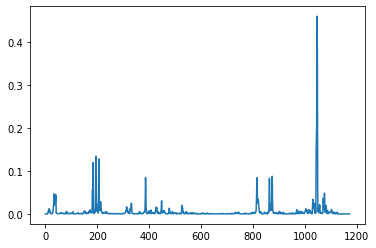

In [171]:
plt.plot(change_rates)

In [182]:
peak_indexes = peakutils.indexes(change_rates, thres=0.1, min_dist=100)

In [183]:
peak_indexes

array([  33,  195,  386,  874, 1047])